In [22]:
import os
from typing import List, TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
import json

from dotenv import load_dotenv
# Load environment variables from .env file
load_dotenv()

True

In [23]:
MAX_MESSAGES_IN_CONTEXT = 10
# Defining the class of the agent
class Agent(TypedDict):
    """
    Defines the state of the agent in the conversation
    messages: A list of chat messages exchanged so far.
    difficulty_level: The current difficulty level of questions (e.g., 'beginner', 'intermediate', 'advanced').
    user_struggle_count: Counter for consecutive times the user struggles.
    topic: The current Python topic being discussed.
    sub_topic: The specific sub-topic within the main topic.
    mcq_active: Boolean indicating if an MCQ is currently active.
    mcq_question: The active MCQ question text.
    mcq_options: List of options for the active MCQ.
    mcq_correct_answer: The correct answer for the active MCQ.
    agent_thought: The last thought process articulated by the Socratic agent.
    next_node: str # The next node the supervisor has decided to route to
    tool_input: dict # Input arguments for the tool if a tool is routed to        
    """
    
    messages: Annotated[List[BaseMessage], add_messages] # Appends new messages to the list
    difficulty_level: str
    user_struggle_count: int
    topic: str
    sub_topic: str
    mcq_active: bool
    mcq_question: str
    mcq_options: List[str]
    mcq_correct_answer: str
    agent_thought: str
    next_node: str
    tool_input: dict

# Initialize the Gemini LLM for the Socratic Agent
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0.7)

In [24]:
# Defining the tools performing the tasks

@tool
def code_analysis_agent(code:str)->str:
    """
    Analyzes the provided Python code, identifies issues, suggests improvements, and provides feedback. 
    Use this when the user provides code and asks for review or debugging. The output will be used by the Socratic agent to ask questions.
    """
    return f"Code Analysis Result: For the code snippet '{code}', a potential area to explore is its efficiency in handling large inputs, or error handling. Also, consider adding comments for clarity."

@tool
def code_explanation_agent(concept: str) -> str:
    """
    Explains a given Python concept, function, keyword, or error message in detail.
    Use this when the user asks for an explanation of something.
    The output is raw explanation, which the Socratic agent will then use to ask questions.
    """
    # In a real scenario, this would call another LLM specialized in explanations.
    return f"Explanation Result: The concept of '{concept}' in Python generally refers to [brief factual summary]. For instance, if it's about 'loops', it describes repetitive execution. If it's 'objects', it's about data and behavior bundling."

@tool
def challenge_generator_agent(topic: str, difficulty: str) -> str:
    """
    Generates a Python coding challenge or a fill-in-the-blanks exercise based on the specified topic and difficulty.
    Use this when the user requests a challenge.
    The output is the challenge, which the Socratic agent will present.
    """
    # In a real scenario, this would call another LLM or a challenge generation service.
    # logger.info(f"Executing Challenge Generation for: {topic}, Difficulty: {difficulty}") # Uncomment when logger is ready
    return f"Challenge Result: For '{topic}' at '{difficulty}' difficulty: 'Write a Python function that takes a list of numbers and returns the sum of all **odd** numbers.' How would you approach solving this?"

@tool
def mcq_agent(topic: str, difficulty: str) -> str:
    """
    Generates a multiple-choice question (MCQ) on a given Python topic and difficulty level.
    The output will be a JSON string containing the question, options, and correct answer.
    This tool is called when the Socratic agent decides to test understanding via MCQ.
    """
    # In a real scenario, this would call another LLM specifically for MCQ generation.
    # logger.info(f"Executing MCQ Generation for: {topic}, Difficulty: {difficulty}") # Uncomment when logger is ready
    mcq_data = {
        "question": f"Which of the following operations would lead to an `IndentationError` in Python?",
        "options": ["A) Missing a colon after a function definition", "B) Inconsistent use of spaces and tabs for indentation", "C) Using a reserved keyword as a variable name", "D) Forgetting a closing parenthesis"],
        "correct_answer": "B"
    }
    return json.dumps(mcq_data)

In [25]:
user_facing_tools = [code_analysis_agent, code_explanation_agent, challenge_generator_agent, mcq_agent]

@tool
def route_to_socratic_question(query: str = None) -> str:
    """Routes the conversation to the main Socratic Questioning agent for general teaching or follow-up.
    This is the default route for general queries, concept discussions, and after tool outputs.
    Optionally includes a follow-up query for the Socratic agent if the intent is specific.
    """
    return "socratic_question"

@tool
def route_to_code_analysis(code: str) -> str:
    """Routes to the Code Analysis agent for debugging or code review. Requires the code snippet."""
    return "code_analysis"

@tool
def route_to_code_explanation(concept: str) -> str:
    """Routes to the Code Explanation agent to explain a specific concept, keyword, or error. Requires the concept."""
    return "code_explanation"

@tool
def route_to_challenge_generator(topic: str = None, difficulty: str = None) -> str:
    """Routes to the Challenge Generator agent to create a coding challenge. Optionally specify topic and difficulty."""
    return "challenge_generator"

@tool
def route_to_mcq_generator(topic: str = None, difficulty: str = None) -> str:
    """Routes to the MCQ Generator agent to create a multiple-choice question. Optionally specify topic and difficulty."""
    return "mcq_generator"

In [26]:
# List of all internal routing tools available to the Supervisor
supervisor_routing_tools = [
    route_to_socratic_question,
    route_to_code_analysis,
    route_to_code_explanation,
    route_to_challenge_generator,
    route_to_mcq_generator
]

# Supervisor Agent Setup
supervisor_system_prompt = """
You are a highly intelligent routing agent for a Socratic Python Tutor. Your task is to analyze
the user's last message and the conversation history to determine the most appropriate next step
in the learning process.

You have access to several internal routing tools. Call exactly one of these tools to specify
which specialized agent or flow should handle the user's request.

Here are your routing rules:
-   **Default:** For general questions, learning new topics, or continuing a Socratic dialogue, use `route_to_socratic_question`. This should be your most frequent choice.
-   **Code Analysis:** If the user provides Python code and asks for debugging, feedback, review, or analysis, use `route_to_code_analysis` and pass the code.
-   **Code Explanation:** If the user explicitly asks for an explanation of a specific Python concept, keyword, function, or error message, use `route_to_code_explanation` and pass the concept.
-   **Challenge/Exercise:** If the user explicitly asks for a coding challenge, exercise, or fill-in-the-blanks, use `route_to_challenge_generator`.
-   **MCQ:** If the user asks for a multiple-choice question or you determine an MCQ is a good way to test their understanding, use `route_to_mcq_generator`.

Pay close attention to keywords and the overall intent. Your response MUST be a tool call.

Current difficulty level: {difficulty_level}
Current topic: {topic}
Current sub-topic: {sub_topic}
"""

supervisor_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", supervisor_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
supervisor_runnable = supervisor_prompt | llm.bind_tools(supervisor_routing_tools)

In [27]:
# Socratic Agent Setup (This is our main Socratic Questioning LLM)
socratic_system_prompt = """
You are a Socratic Python programming tutor. Your goal is to guide the user to discover answers
and understand concepts through thoughtful questions, rather than directly providing solutions.

Here are your core principles:
1.  **Ask Questions:** Always respond with a question, unless explicitly providing feedback on code or an MCQ answer.
2.  **Socratic Method:** Break down complex problems into smaller, manageable questions.
3.  **Encourage Exploration:** Prompt the user to experiment, research, or think critically.
4.  **Adapt to User Understanding:**
    * **Struggle Detection:** If the user seems confused, provides incorrect answers, or asks for direct solutions, simplify your questions, rephrase, or offer a hint.
    * **Progression:** If the user demonstrates understanding, subtly move to a slightly more advanced sub-concept or a related new topic. Avoid repetitive questioning on the same point.
5.  **Interpret Tool Outputs Socratically:** If a tool provides information (e.g., Code Analysis Result, Explanation Result, Challenge Result), your task is to *process that information* and turn it into a Socratic question or guided step for the user. Do not just relay the tool's output directly.
6.  **Maintain Context:** Keep track of the current topic and sub-topic.
7.  **Be Patient and Encouraging:** Foster a positive learning environment.
8.  **ReAct Architecture (Internal Thought):** Before responding, articulate your thought process. Start your response with "Thought: [Your reasoning here]". This thought will be logged but not shown to the user. Then, proceed with your Socratic question.

Current difficulty level: {difficulty_level}
Current topic: {topic}
Current sub-topic: {sub_topic}
User struggle count: {user_struggle_count}
MCQ active: {mcq_active}
"""

socratic_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", socratic_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
socratic_agent_runnable = socratic_prompt | llm

In [29]:
def call_supervisor(state: Agent):
    """
    Node for the supervisor to determine the next action/agent based on user intent.
    """
    # logger.info("Supervisor node activated.") # Uncomment when logger is ready
    messages = state["messages"][-MAX_MESSAGES_IN_CONTEXT:] # Apply truncation here
    # Pass the full state to the prompt for contextual awareness in routing
    response = supervisor_runnable.invoke({
        "messages": messages,
        "difficulty_level": state["difficulty_level"],
        "user_struggle_count": state["user_struggle_count"],
        "topic": state["topic"],
        "sub_topic": state["sub_topic"]
    })

    # The supervisor is expected to call one of its internal routing tools.
    # Extract the tool call and set the next_node and tool_input in the state.
    if response.tool_calls:
        tool_call = response.tool_calls[0] # Assuming supervisor calls one tool
        next_node = tool_call.name.replace("route_to_", "") # Extract node name (e.g., "socratic_question")
        tool_input = tool_call.args
        # logger.info(f"Supervisor decided to route to: {next_node} with input: {tool_input}") # Uncomment when logger is ready
        return {"messages": [response], "next_node": next_node, "tool_input": tool_input}
    else:
        # Fallback if supervisor doesn't call a tool (shouldn't happen with proper prompt)
        # Force it to the socratic question node
        # logger.warning("Supervisor did not call a tool. Defaulting to socratic_question.") # Uncomment when logger is ready
        return {"messages": [response], "next_node": "socratic_question"}


def socratic_question_node(state: Agent):
    """
    Node for the main Socratic LLM to ask questions or interpret tool outputs.
    """
    # logger.info("Socratic Question Node activated.") # Uncomment when logger is ready
    messages = state["messages"][-MAX_MESSAGES_IN_CONTEXT:] # Apply truncation here
    response = socratic_agent_runnable.invoke({
        "messages": messages,
        "difficulty_level": state["difficulty_level"],
        "user_struggle_count": state["user_struggle_count"],
        "topic": state["topic"],
        "sub_topic": state["sub_topic"],
        "mcq_active": state["mcq_active"]
    })

    # Extract thought (for logging)
    thought = ""
    if response.content and response.content.startswith("Thought:"):
        parts = response.content.split("Thought:", 1)
        if len(parts) > 1:
            thought = parts[1].strip().split('\n', 1)[0]

    return {"messages": [response], "agent_thought": thought}


def call_specialized_tool_node(state: Agent):
    """
    Node to execute a specialized user-facing tool based on supervisor's decision.
    """
    # logger.info(f"Call Specialized Tool Node activated for {state['next_node']}") # Uncomment when logger is ready
    tool_name = state["next_node"] # This comes from the supervisor's routing decision
    tool_args = state["tool_input"]

    # Manually find and execute the tool function
    tool_function = next((t for t in user_facing_tools if t.name == tool_name), None)

    tool_output = ""
    if tool_function:
        try:
            tool_output = tool_function(**tool_args)
            # logger.info(f"Tool '{tool_name}' executed. Output: {tool_output[:100]}...") # Uncomment when logger is ready
        except Exception as e:
            tool_output = f"Error executing tool {tool_name}: {e}"
            # logger.error(f"Error executing tool {tool_name}: {e}", exc_info=True) # Uncomment when logger is ready
    else:
        tool_output = f"Error: Specialized tool '{tool_name}' not found."
        # logger.error(f"Specialized tool '{tool_name}' not found.") # Uncomment when logger is ready

    # Add the tool output as a ToolMessage to the conversation history
    # The socratic_question_node will then process this and ask a question.
    return {"messages": [ToolMessage(content=tool_output, name=tool_name)]}


def generate_mcq_node(state: Agent):
    """
    Node specifically for generating an MCQ via the mcq_agent tool.
    This also handles setting the MCQ active state for main.py.
    """
    # logger.info("MCQ Generation Node activated.") # Uncomment when logger is ready
    tool_name = "mcq_agent"
    tool_args = state["tool_input"] # Should contain topic and difficulty from supervisor

    tool_function = next((t for t in user_facing_tools if t.name == tool_name), None)
    mcq_raw_output = ""

    if tool_function:
        try:
            mcq_raw_output = tool_function(**tool_args)
            mcq_data = json.loads(mcq_raw_output)
            state["mcq_active"] = True
            state["mcq_question"] = mcq_data["question"]
            state["mcq_options"] = mcq_data["options"]
            state["mcq_correct_answer"] = mcq_data["correct_answer"]
            # logger.info("MCQ details updated in state.") # Uncomment when logger is ready
        except Exception as e:
            mcq_raw_output = f"Error generating MCQ: {e}"
            # logger.error(f"Error generating MCQ: {e}", exc_info=True) # Uncomment when logger is ready
    
    # Add a ToolMessage for the MCQ generation, which the Socratic LLM can interpret
    # or simply for logging purposes in the graph flow.
    return {"messages": [ToolMessage(content=mcq_raw_output, name=tool_name)], **state}

In [30]:
# --- 4. Define the Graph Edges (Conditional Logic) ---

def route_supervisor_output(state: Agent):
    """
    Conditional edge from the supervisor to determine the next node based on its decision.
    """
    # logger.info(f"Routing supervisor output. Next node: {state['next_node']}") # Uncomment when logger is ready
    if state["next_node"] == "socratic_question":
        return "socratic_question_node"
    elif state["next_node"] == "mcq_generator":
        return "generate_mcq_node"
    # All other specialized tools go through the generic tool calling node
    elif state["next_node"] in ["code_analysis", "code_explanation", "challenge_generator"]:
        return "call_specialized_tool_node"
    return "socratic_question_node" # Fallback to socratic question if unexpected



In [46]:
workflow = StateGraph(Agent)

# Add nodes to the workflow.
workflow.add_node("call_supervisor", call_supervisor)
workflow.add_node("socratic_question_node", socratic_question_node) # Renamed from call_llm
workflow.add_node("call_specialized_tool_node", call_specialized_tool_node)
workflow.add_node("generate_mcq_node", generate_mcq_node)

# Set the entry point for the graph.
workflow.set_entry_point("call_supervisor")

# Define the edges.
# From supervisor, route conditionally
workflow.add_conditional_edges(
    "call_supervisor",
    route_supervisor_output,
    {
        "socratic_question_node": "socratic_question_node",
        "call_specialized_tool_node": "call_specialized_tool_node",
        "generate_mcq_node": "generate_mcq_node",
    }
)

# After a specialized tool (other than MCQ), return to the socratic_question_node
# for the Socratic LLM to interpret the tool's output and formulate a question.
workflow.add_edge("call_specialized_tool_node", "socratic_question_node")

# After the socratic_question_node, the run ends. The main.py loop will then take user input.
workflow.add_edge("socratic_question_node", END)

# After generating an MCQ, the run ends. Main.py handles the MCQ display and user input.
workflow.add_edge("generate_mcq_node", END)

# Initialize MemorySaver
# This will save conversation state to a local file system by default.
# checkpointer = MemorySaver()

# Compile the graph into a runnable agent with the checkpointer.
socratic_graph = workflow.compile()

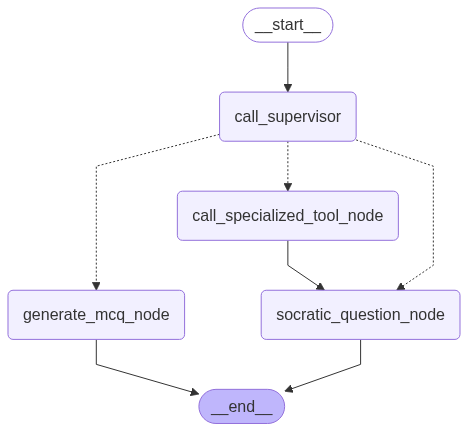

In [47]:
socratic_graph

In [50]:
# --- Temporary LLM Connection Test ---
# This function will be called once when the module is imported to test LLM connectivity.
def _test_llm_connection():
    print("\n--- Testing LLM Connection (Temporary) ---")
    try:
        test_message = HumanMessage(content="Say hi!")
        response = llm.invoke([test_message])
        print(f"LLM Test Response: {response.content}")
        print("LLM connection successful!")
    except Exception as e:
        print(f"LLM Connection Test FAILED: {e}")
        print("Please check your GOOGLE_API_KEY and network connection.")
    print("--- End LLM Connection Test ---\n")

# --- Temporary Node Functionality Test ---
# This function allows testing individual nodes with a sample state.
def _test_node_functionality(node_name: str, initial_state: Agent):
    print(f"\n--- Testing Node: {node_name} ---")
    try:
        # Get the node function from the workflow's nodes
        # Access the runnable attribute to get the actual function
        # This is the fix for 'StateNodeSpec' object is not callable
        node_runnable = workflow.nodes[node_name].runnable

        # Invoke the node's runnable with the provided initial state
        # For nodes that are LLMChain or similar, invoke with a dict matching their input schema
        # For simple functions, it might be direct call.
        # Here, we assume the node_runnable expects the full state dict as input,
        # which is how LangGraph nodes are typically defined.
        result_state_update = node_runnable.invoke(initial_state)


        print(f"Node '{node_name}' executed successfully.")
        print(f"Initial State (messages only): {[msg.content if hasattr(msg, 'content') else str(msg) for msg in initial_state['messages']]}")
        print(f"Resulting State Update: {result_state_update}")

        # For nodes that return messages, let's print them
        if 'messages' in result_state_update and result_state_update['messages']:
            print("Messages returned by node:")
            for msg in result_state_update['messages']:
                if isinstance(msg, BaseMessage):
                    print(f"  - Type: {msg.type}, Content: {msg.content[:50]}...")
                    if hasattr(msg, 'tool_calls') and msg.tool_calls:
                        # Ensure tool_calls are correctly converted to ToolCall objects
                        # This part of the debug print itself needs to be robust
                        for tc in msg.tool_calls:
                            if isinstance(tc, ToolCall):
                                print(f"    Tool Call: {tc.function.name} with args {tc.function.arguments}")
                            else:
                                print(f"    Raw Tool Call (still dict?): {tc}")
                else:
                    print(f"  - Raw: {msg}")

    except Exception as e:
        print(f"Node '{node_name}' Test FAILED: {e}")
        import traceback
        traceback.print_exc() # Print full traceback for node errors
    print(f"--- End Node Test: {node_name} ---\n")


# Call the LLM connection test immediately when this module is loaded
# _test_llm_connection()

# Example usage of the new node testing function (uncomment to test specific nodes)
# Ensure your GOOGLE_API_KEY is set for LLM-based nodes.

# Test call_supervisor node
sample_supervisor_state = Agent(
    messages=[HumanMessage(content="I need help with debugging this code: print('hello')")],
    difficulty_level="beginner",
    user_struggle_count=0,
    topic="Python Basics",
    sub_topic="Introduction",
    mcq_active=False,
    mcq_question="", mcq_options=[], mcq_correct_answer="",
    agent_thought="", next_node="", tool_input={}
)
_test_node_functionality("call_supervisor", sample_supervisor_state)

# Test socratic_question_node
# sample_socratic_state = SocraticAgentState(
#     messages=[HumanMessage(content="What are variables?"), AIMessage(content="Thought: User asked about variables. I should ask a foundational question. What is your current understanding of variables in programming?")],
#     difficulty_level="beginner",
#     user_struggle_count=0,
#     topic="Variables",
#     sub_topic="Definition",
#     mcq_active=False,
#     mcq_question="", mcq_options=[], mcq_correct_answer="",
#     agent_thought="", next_node="", tool_input={}
# )
# _test_node_functionality("socratic_question_node", sample_socratic_state)

# Test call_specialized_tool_node (e.g., code_analysis)
# This requires the supervisor to have set next_node and tool_input previously.
# For a direct test, we simulate that state.
# sample_tool_state_code_analysis = SocraticAgentState(
#     messages=[HumanMessage(content="debug this code: print('hello')")],
#     difficulty_level="beginner",
#     user_struggle_count=0,
#     topic="Debugging",
#     sub_topic="Code Analysis",
#     mcq_active=False,
#     mcq_question="", mcq_options=[], mcq_correct_answer="",
#     agent_thought="",
#     next_node="code_analysis", # Supervisor would set this
#     tool_input={"code": "def my_func():\n    pass"} # Supervisor would set this
# )
# _test_node_functionality("call_specialized_tool_node", sample_tool_state_code_analysis)

# Test generate_mcq_node
# sample_mcq_state = SocraticAgentState(
#     messages=[HumanMessage(content="Give me an MCQ on functions.")],
#     difficulty_level="beginner",
#     user_struggle_count=0,
#     topic="Functions",
#     sub_topic="MCQ",
#     mcq_active=False,
#     mcq_question="", mcq_options=[], mcq_correct_answer="",
#     agent_thought="",
#     next_node="mcq_generator", # Supervisor would set this
#     tool_input={"topic": "functions", "difficulty": "beginner"} # Supervisor would set this
# )
# _test_node_functionality("generate_mcq_node", sample_mcq_state)


--- Testing Node: call_supervisor ---
Node 'call_supervisor' Test FAILED: 'dict' object has no attribute 'name'
--- End Node Test: call_supervisor ---



Traceback (most recent call last):
  File "/tmp/ipykernel_12503/4231620347.py", line 30, in _test_node_functionality
    result_state_update = node_runnable.invoke(initial_state)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.python/current/lib/python3.12/site-packages/langgraph/utils/runnable.py", line 377, in invoke
    ret = self.func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_12503/542529847.py", line 20, in call_supervisor
    next_node = tool_call.name.replace("route_to_", "") # Extract node name (e.g., "socratic_question")
                ^^^^^^^^^^^^^^
AttributeError: 'dict' object has no attribute 'name'


In [ ]:
# socratic_bot_logic.py

import os
from typing import List, TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage, ToolCall
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langchain_core.tools import tool # Ensure tool decorator is imported
import json
import uuid # Import uuid for generating unique IDs

# Removed MemorySaver import
# from langgraph.checkpoint.memory import MemorySaver

# Import the logging utility (assuming logger.py will be created later)
# from logger import setup_logger
# logger = setup_logger() # Uncomment when logger.py is ready

# --- Configuration for Memory Management ---
MAX_MESSAGES_IN_CONTEXT = 10 # Keep the last 10 messages in the context window
# This includes both HumanMessage and AIMessage. Adjust as needed based on LLM context limits.

# --- 1. Define the Agent State ---
class SocraticAgentState(TypedDict):
    """
    Represents the state of the Socratic agent's conversation.

    Attributes:
        messages: A list of chat messages exchanged so far.
        difficulty_level: The current difficulty level of questions (e.g., 'beginner', 'intermediate', 'advanced').
        user_struggle_count: Counter for consecutive times the user struggles.
        topic: The current Python topic being discussed.
        sub_topic: The specific sub-topic within the main topic.
        mcq_active: Boolean indicating if an MCQ is currently active.
        mcq_question: The active MCQ question text.
        mcq_options: List of options for the active MCQ.
        mcq_correct_answer: The correct answer for the active MCQ.
        agent_thought: The last thought process articulated by the Socratic agent.
        # Added for supervisor routing
        next_node: str # The next node the supervisor has decided to route to
        tool_input: dict # Input arguments for the tool if a tool is routed to
    """
    messages: Annotated[List[BaseMessage], lambda x, y: x + y] # Appends new messages to the list
    difficulty_level: str
    user_struggle_count: int
    topic: str
    sub_topic: str
    mcq_active: bool
    mcq_question: str
    mcq_options: List[str]
    mcq_correct_answer: str
    agent_thought: str
    next_node: str
    tool_input: dict


# --- 2. Initialize the LLMs and Tools ---

# Initialize the Gemini LLM (used for both Socratic and Supervisor agents)
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0.7)

# --- Define User-Facing Simulated Agent Tools ---
# These are the actual tools that will perform specific tasks.
@tool
def code_analysis_agent(code: str) -> str:
    """
    Analyzes the provided Python code, identifies potential issues, suggests improvements,
    and provides feedback. Use this when the user provides code and asks for review or debugging.
    The output is raw analysis, which the Socratic agent will then use to ask questions.
    """
    # In a real scenario, this would call another LLM or a static analysis tool.
    # logger.info(f"Executing Code Analysis for: {code[:50]}...") # Uncomment when logger is ready
    return f"Code Analysis Result: For the code snippet '{code}', a potential area to explore is its efficiency in handling large inputs, or error handling. Also, consider adding comments for clarity."

@tool
def code_explanation_agent(concept: str) -> str:
    """
    Explains a given Python concept, function, keyword, or error message in detail.
    Use this when the user asks for an explanation of something.
    The output is raw explanation, which the Socratic agent will then use to ask questions.
    """
    # In a real scenario, this would call another LLM specialized in explanations.
    # logger.info(f"Executing Code Explanation for: {concept}") # Uncomment when logger is ready
    return f"Explanation Result: The concept of '{concept}' in Python generally refers to [brief factual summary]. For instance, if it's about 'loops', it's about repetitive execution. If it's 'objects', it's about data and behavior bundling."

@tool
def challenge_generator_agent(topic: str, difficulty: str) -> str:
    """
    Generates a Python coding challenge or a fill-in-the-blanks exercise based on the specified topic and difficulty.
    Use this when the user requests a challenge.
    The output is the challenge, which the Socratic agent will present.
    """
    # In a real scenario, this would call another LLM or a challenge generation service.
    # logger.info(f"Executing Challenge Generation for: {topic}, Difficulty: {difficulty}") # Uncomment when logger is ready
    return f"Challenge Result: For '{topic}' at '{difficulty}' difficulty: 'Write a Python function that takes a list of numbers and returns the sum of all **odd** numbers.' How would you approach solving this?"

@tool
def mcq_agent(topic: str, difficulty: str) -> str:
    """
    Generates a multiple-choice question (MCQ) on a given Python topic and difficulty level.
    The output will be a JSON string containing the question, options, and correct answer.
    This tool is called when the Socratic agent decides to test understanding via MCQ.
    """
    # In a real scenario, this would call another LLM specifically for MCQ generation.
    # logger.info(f"Executing MCQ Generation for: {topic}, Difficulty: {difficulty}") # Uncomment when logger is ready
    mcq_data = {
        "question": f"Which of the following operations would lead to an `IndentationError` in Python?",
        "options": ["A) Missing a colon after a function definition", "B) Inconsistent use of spaces and tabs for indentation", "C) Using a reserved keyword as a variable name", "D) Forgetting a closing parenthesis"],
        "correct_answer": "B"
    }
    return json.dumps(mcq_data)

# List of all user-facing tools
user_facing_tools = [code_analysis_agent, code_explanation_agent, challenge_generator_agent, mcq_agent]

# --- Define Internal Supervisor Tools (for routing decisions) ---
# These are "tools" the supervisor LLM will call to indicate its routing decision.
@tool
def route_to_socratic_question(query: str = None) -> str:
    """Routes the conversation to the main Socratic Questioning agent for general teaching or follow-up.
    This is the default route for general queries, concept discussions, and after tool outputs.
    Optionally includes a follow-up query for the Socratic agent if the intent is specific.
    """
    return "socratic_question"

@tool
def route_to_code_analysis(code: str) -> str:
    """Routes to the Code Analysis agent for debugging or code review. Requires the code snippet."""
    return "code_analysis"

@tool
def route_to_code_explanation(concept: str) -> str:
    """Routes to the Code Explanation agent to explain a specific concept, keyword, or error. Requires the concept."""
    return "code_explanation"

@tool
def route_to_challenge_generator(topic: str = None, difficulty: str = None) -> str:
    """Routes to the Challenge Generator agent to create a coding challenge. Optionally specify topic and difficulty."""
    return "challenge_generator"

@tool
def route_to_mcq_generator(topic: str = None, difficulty: str = None) -> str:
    """Routes to the MCQ Generator agent to create a multiple-choice question. Optionally specify topic and difficulty."""
    return "mcq_generator"

# List of all internal routing tools available to the Supervisor
supervisor_routing_tools = [
    route_to_socratic_question,
    route_to_code_analysis,
    route_to_code_explanation,
    route_to_challenge_generator,
    route_to_mcq_generator
]

# Supervisor Agent Setup
supervisor_system_prompt = """
You are a highly intelligent routing agent for a Socratic Python Tutor. Your task is to analyze
the user's last message and the conversation history to determine the most appropriate next step
in the learning process.

You have access to several internal routing tools. Call exactly one of these tools to specify
which specialized agent or flow should handle the user's request.

Here are your routing rules:
-   **Default:** For general questions, learning new topics, or continuing a Socratic dialogue, use `route_to_socratic_question`. This should be your most frequent choice.
-   **Code Analysis:** If the user provides Python code and asks for debugging, feedback, review, or analysis, use `route_to_code_analysis` and pass the code.
-   **Code Explanation:** If the user explicitly asks for an explanation of a specific Python concept, keyword, or error message, use `route_to_code_explanation` and pass the concept.
-   **Challenge/Exercise:** If the user explicitly asks for a coding challenge, exercise, or fill-in-the-blanks, use `route_to_challenge_generator`.
-   **MCQ:** If the user asks for a multiple-choice question or you determine an MCQ is a good way to test their understanding, use `route_to_mcq_generator`.

Pay close attention to keywords and the overall intent. Your response MUST be a tool call.

Current difficulty level: {difficulty_level}
Current topic: {topic}
Current sub-topic: {sub_topic}
"""

supervisor_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", supervisor_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
supervisor_runnable = supervisor_prompt | llm.bind_tools(supervisor_routing_tools)

# Socratic Agent Setup (This is our main Socratic Questioning LLM)
socratic_system_prompt = """
You are a Socratic Python programming tutor. Your goal is to guide the user to discover answers
and understand concepts through thoughtful questions, rather than directly providing solutions.

Here are your core principles:
1.  **Ask Questions:** Always respond with a question, unless explicitly providing feedback on code or an MCQ answer.
2.  **Socratic Method:** Break down complex problems into smaller, manageable questions.
3.  **Encourage Exploration:** Prompt the user to experiment, research, or think critically.
4.  **Adapt to User Understanding:**
    * **Struggle Detection:** If the user seems confused, provides incorrect answers, or asks for direct solutions, simplify your questions, rephrase, or offer a hint.
    * **Progression:** If the user demonstrates understanding, subtly move to a slightly more advanced sub-concept or a related new topic. Avoid repetitive questioning on the same point.
5.  **Interpret Tool Outputs Socratically:** If a tool provides information (e.g., Code Analysis Result, Explanation Result, Challenge Result), your task is to *process that information* and turn it into a Socratic question or guided step for the user. Do not just relay the tool's output directly.
6.  **Maintain Context:** Keep track of the current topic and sub-topic.
7.  **Be Patient and Encouraging:** Foster a positive learning environment.
8.  **ReAct Architecture (Internal Thought):** Before responding, articulate your thought process. Start your response with "Thought: [Your reasoning here]". This thought will be logged but not shown to the user. Then, proceed with your Socratic question.

Current difficulty level: {difficulty_level}
Current topic: {topic}
Current sub-topic: {sub_topic}
User struggle count: {user_struggle_count}
MCQ active: {mcq_active}
"""

socratic_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", socratic_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
socratic_agent_runnable = socratic_prompt | llm # Socratic agent does not call tools directly, supervisor does

# --- 3. Define the Graph Nodes ---

def call_supervisor(state: SocraticAgentState):
    """
    Node for the supervisor to determine the next action/agent based on user intent.
    """
    # logger.info("Supervisor node activated.") # Uncomment when logger is ready
    messages = state["messages"][-MAX_MESSAGES_IN_CONTEXT:] # Apply truncation here
    # Pass the full state to the prompt for contextual awareness in routing
    response = supervisor_runnable.invoke({
        "messages": messages,
        "difficulty_level": state["difficulty_level"],
        "user_struggle_count": state["user_struggle_count"],
        "topic": state["topic"],
        "sub_topic": state["sub_topic"]
    })

    # The supervisor is expected to call one of its internal routing tools.
    # Extract the tool call and set the next_node and tool_input in the state.
    if response.tool_calls:
        # Access tool name from the 'function' dict within the tool_call dictionary
        # tool_call is a dictionary here, not a ToolCall object
        tool_call_dict = response.tool_calls[0]
        tool_name = tool_call_dict.get('function', {}).get('name')
        tool_input = tool_call_dict.get('function', {}).get('arguments') # Arguments are also nested

        # IMPORTANT: Add a check here if tool_name is None, indicating a malformed tool call
        if tool_name is None:
            print("Warning: Supervisor LLM returned a malformed tool call (name is None). Defaulting to socratic_question.")
            return {"messages": [response], "next_node": "socratic_question"}

        next_node = tool_name.replace("route_to_", "") # Extract node name (e.g., "socratic_question")
        # logger.info(f"Supervisor decided to route to: {next_node} with input: {tool_input}") # Uncomment when logger is ready
        return {"messages": [response], "next_node": next_node, "tool_input": tool_input}
    else:
        # Fallback if supervisor doesn't call a tool (shouldn't happen with proper prompt)
        # Force it to the socratic question node
        print("Warning: Supervisor LLM did not call a tool. Defaulting to socratic_question.")
        return {"messages": [response], "next_node": "socratic_question"}


def socratic_question_node(state: SocraticAgentState):
    """
    Node for the main Socratic LLM to ask questions or interpret tool outputs.
    """
    # logger.info("Socratic Question Node activated.") # Uncomment when logger is ready
    messages = state["messages"][-MAX_MESSAGES_IN_CONTEXT:] # Apply truncation here
    response = socratic_agent_runnable.invoke({
        "messages": messages,
        "difficulty_level": state["difficulty_level"],
        "user_struggle_count": state["user_struggle_count"],
        "topic": state["topic"],
        "sub_topic": state["sub_topic"],
        "mcq_active": state["mcq_active"]
    })

    # Extract thought (for logging)
    thought = ""
    if response.content and response.content.startswith("Thought:"):
        parts = response.content.split("Thought:", 1)
        if len(parts) > 1:
            thought = parts[1].strip().split('\n', 1)[0]

    return {"messages": [response], "agent_thought": thought}


def call_specialized_tool_node(state: SocraticAgentState):
    """
    Node to execute a specialized user-facing tool based on supervisor's decision.
    """
    # logger.info(f"Call Specialized Tool Node activated for {state['next_node']}") # Uncomment when logger is ready
    tool_name = state["next_node"] # This comes from the supervisor's routing decision
    tool_args = state["tool_input"]

    # Manually find and execute the tool function
    tool_function = next((t for t in user_facing_tools if t.name == tool_name), None)

    tool_output = ""
    if tool_function:
        try:
            tool_output = tool_function(**tool_args)
            # logger.info(f"Tool '{tool_name}' executed. Output: {tool_output[:100]}...") # Uncomment when logger is ready
        except Exception as e:
            tool_output = f"Error executing tool {tool_name}: {e}"
            # logger.error(f"Error executing tool {tool_name}: {e}", exc_info=True) # Uncomment when logger is ready
    else:
        tool_output = f"Error: Specialized tool '{tool_name}' not found."
        # logger.error(f"Specialized tool '{tool_name}' not found.") # Uncomment when logger is ready

    # Add the tool output as a ToolMessage to the conversation history
    # The socratic_question_node will then process this and ask a question.
    # Provide a unique tool_call_id for the ToolMessage
    return {"messages": [ToolMessage(content=tool_output, name=tool_name, tool_call_id=str(uuid.uuid4()))]}


def generate_mcq_node(state: SocraticAgentState):
    """
    Node specifically for generating an MCQ via the mcq_agent tool.
    This also handles setting the MCQ active state for main.py.
    """
    # logger.info("MCQ Generation Node activated.") # Uncomment when logger is ready
    tool_name = state["next_node"] # This comes from the supervisor's routing decision
    tool_args = state["tool_input"] # Should contain topic and difficulty from supervisor

    tool_function = next((t for t in user_facing_tools if t.name == tool_name), None)
    mcq_raw_output = ""

    if tool_function:
        try:
            mcq_raw_output = tool_function(**tool_args)
            mcq_data = json.loads(mcq_raw_output)
            state["mcq_active"] = True
            state["mcq_question"] = mcq_data["question"]
            state["mcq_options"] = mcq_data["options"]
            state["mcq_correct_answer"] = mcq_data["correct_answer"]
            # logger.info("MCQ details updated in state.") # Uncomment when logger is ready
        except Exception as e:
            mcq_raw_output = f"Error generating MCQ: {e}"
            # logger.error(f"Error generating MCQ: {e}", exc_info=True) # Uncomment when logger is ready
    
    # Add a ToolMessage for the MCQ generation, which the Socratic LLM can interpret
    # or simply for logging purposes in the graph flow.
    # Provide a unique tool_call_id for the ToolMessage
    return {"messages": [ToolMessage(content=mcq_raw_output, name=tool_name, tool_call_id=str(uuid.uuid4()))], **state}


# --- 4. Define the Graph Edges (Conditional Logic) ---

def route_supervisor_output(state: SocraticAgentState):
    """
    Conditional edge from the supervisor to determine the next node based on its decision.
    """
    # logger.info(f"Routing supervisor output. Next node: {state['next_node']}") # Uncomment when logger is ready
    if state["next_node"] == "socratic_question":
        return "socratic_question_node"
    elif state["next_node"] == "mcq_generator":
        return "generate_mcq_node"
    # All other specialized tools go through the generic tool calling node
    elif state["next_node"] in ["code_analysis", "code_explanation", "challenge_generator"]:
        return "call_specialized_tool_node"
    return "socratic_question_node" # Fallback to socratic question if unexpected


# --- 5. Build the LangGraph ---

# Create a StateGraph instance with our defined state.
workflow = StateGraph(SocraticAgentState)

# Add nodes to the workflow.
workflow.add_node("call_supervisor", call_supervisor)
workflow.add_node("socratic_question_node", socratic_question_node) # Renamed from call_llm
workflow.add_node("call_specialized_tool_node", call_specialized_tool_node)
workflow.add_node("generate_mcq_node", generate_mcq_node)

# Set the entry point for the graph.
workflow.set_entry_point("call_supervisor")

# Define the edges.
# From supervisor, route conditionally
workflow.add_conditional_edges(
    "call_supervisor",
    route_supervisor_output,
    {
        "socratic_question_node": "socratic_question_node",
        "call_specialized_tool_node": "call_specialized_tool_node",
        "generate_mcq_node": "generate_mcq_node",
    }
)

# After a specialized tool (other than MCQ), return to the socratic_question_node
# for the Socratic LLM to interpret the tool's output and formulate a question.
workflow.add_edge("call_specialized_tool_node", "socratic_question_node")

# After the socratic_question_node, the run ends. The main.py loop will then take user input.
workflow.add_edge("socratic_question_node", END)

# After generating an MCQ, the run ends. Main.py handles the MCQ display and user input.
workflow.add_edge("generate_mcq_node", END)

# Removed MemorySaver initialization and compilation
# checkpointer = MemorySaver()
socratic_graph = workflow.compile() # Compile without checkpointer

# --- Temporary LLM Connection Test ---
# This function will be called once when the module is imported to test LLM connectivity.
def _test_llm_connection():
    print("\n--- Testing LLM Connection (Temporary) ---")
    try:
        test_message = HumanMessage(content="Say hi!")
        response = llm.invoke([test_message])
        print(f"LLM Test Response: {response.content}")
        print("LLM connection successful!")
    except Exception as e:
        print(f"LLM Connection Test FAILED: {e}")
        print("Please check your GOOGLE_API_KEY and network connection.")
    print("--- End LLM Connection Test ---\n")

# --- Temporary Node Functionality Test ---
# This function allows testing individual nodes with a sample state.
def _test_node_functionality(node_name: str, initial_state: SocraticAgentState):
    print(f"\n--- Testing Node: {node_name} ---")
    try:
        # Get the node function from the workflow's nodes
        # Access the runnable attribute to get the actual function
        node_runnable = workflow.nodes[node_name].runnable

        # Invoke the node's runnable with the provided initial state
        result_state_update = node_runnable.invoke(initial_state)


        print(f"Node '{node_name}' executed successfully.")
        print(f"Initial State (messages only): {[msg.content if hasattr(msg, 'content') else str(msg) for msg in initial_state['messages']]}")
        print(f"Resulting State Update: {result_state_update}")

        # For nodes that return messages, let's print them
        if 'messages' in result_state_update and result_state_update['messages']:
            print("Messages returned by node:")
            for msg in result_state_update['messages']:
                if isinstance(msg, BaseMessage):
                    print(f"  - Type: {msg.type}, Content: {msg.content[:50]}...")
                    if hasattr(msg, 'tool_calls') and msg.tool_calls:
                        # Ensure tool_calls are correctly converted to ToolCall objects
                        for tc in msg.tool_calls:
                            if isinstance(tc, ToolCall):
                                print(f"    Tool Call: {tc.function.name} with args {tc.function.arguments}")
                            else:
                                # Fallback for debugging if it's still a dict
                                print(f"    Raw Tool Call (still dict?): {tc}")
                                print(f"    Attempting dict access: Name={tc.get('function', {}).get('name')}, Args={tc.get('function', {}).get('arguments')}")
                else:
                    print(f"  - Raw: {msg}")

    except Exception as e:
        print(f"Node '{node_name}' Test FAILED: {e}")
        import traceback
        traceback.print_exc() # Print full traceback for node errors
    print(f"--- End Node Test: {node_name} ---\n")


# Call the LLM connection test immediately when this module is loaded
_test_llm_connection()

# Example usage of the new node testing function (uncomment to test specific nodes)
# Ensure your GOOGLE_API_KEY is set for LLM-based nodes.

# Test call_supervisor node
# sample_supervisor_state = SocraticAgentState(
#     messages=[HumanMessage(content="I need help with debugging this code: print('hello')")],
#     difficulty_level="beginner",
#     user_struggle_count=0,
#     topic="Python Basics",
#     sub_topic="Introduction",
#     mcq_active=False,
#     mcq_question="", mcq_options=[], mcq_correct_answer="",
#     agent_thought="", next_node="", tool_input={}
# )
# _test_node_functionality("call_supervisor", sample_supervisor_state)

# Test socratic_question_node
# sample_socratic_state = SocraticAgentState(
#     messages=[HumanMessage(content="What are variables?"), AIMessage(content="Thought: User asked about variables. I should ask a foundational question. What is your current understanding of variables in programming?")],
#     difficulty_level="beginner",
#     user_struggle_count=0,
#     topic="Variables",
#     sub_topic="Definition",
#     mcq_active=False,
#     mcq_question="", mcq_options=[], mcq_correct_answer="",
#     agent_thought="", next_node="", tool_input={}
# )
# _test_node_functionality("socratic_question_node", sample_socratic_state)

# Test call_specialized_tool_node (e.g., code_analysis)
# This requires the supervisor to have set next_node and tool_input previously.
# For a direct test, we simulate that state.
# sample_tool_state_code_analysis = SocraticAgentState(
#     messages=[HumanMessage(content="debug this code: print('hello')")],
#     difficulty_level="beginner",
    # user_struggle_count=0,
#     topic="Debugging",
#     sub_topic="Code Analysis",
#     mcq_active=False,
#     mcq_question="", mcq_options=[], mcq_correct_answer="",
#     agent_thought="",
#     next_node="code_analysis", # Supervisor would set this
#     tool_input={"code": "def my_func():\n    pass"} # Supervisor would set this
# )
# _test_node_functionality("call_specialized_tool_node", sample_tool_state_code_analysis)

# Test generate_mcq_node
# sample_mcq_state = SocraticAgentState(
#     messages=[HumanMessage(content="Give me an MCQ on functions.")],
#     difficulty_level="beginner",
#     user_struggle_count=0,
#     topic="Functions",
#     sub_topic="MCQ",
#     mcq_active=False,
    # mcq_question="", mcq_options=[], mcq_correct_answer="",
#     agent_thought="",
#     next_node="mcq_generator", # Supervisor would set this
#     tool_input={"topic": "functions", "difficulty": "beginner"} # Supervisor would set this
# )
# _test_node_functionality("generate_mcq_node", sample_mcq_state)



--- Testing LLM Connection (Temporary) ---
LLM Test Response: Hi!
LLM connection successful!
--- End LLM Connection Test ---


--- Testing Node: call_supervisor ---
Node 'call_supervisor' executed successfully.
Initial State (messages only): ["I need help with debugging this code: print('hello')"]
Resulting State Update: {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'route_to_code_analysis', 'arguments': '{"code": "print(\'hello\')"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run--06323891-6036-4975-a936-116d611be354-0', tool_calls=[{'name': 'route_to_code_analysis', 'args': {'code': "print('hello')"}, 'id': '51843dc3-a8f5-44f8-8e55-999f38e2e0f4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 533, 'output_tokens': 12, 'total_tokens': 545, 'input_token_details': {'cache_read': 0}})], 'next_node': 'socratic_question'}

Traceback (most recent call last):
  File "/tmp/ipykernel_12503/3269865442.py", line 442, in _test_node_functionality
    if isinstance(tc, ToolCall):
       ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packages/typing_extensions.py", line 1102, in __subclasscheck__
    raise TypeError('TypedDict does not support instance and class checks')
TypeError: TypedDict does not support instance and class checks


In [ ]:
import logging
from socratic_bot_logic import SocraticBot
from langchain_core.messages import HumanMessage, AIMessage
from config import load_environment_variables
from logger import setup_logging

def main():
# Set up logging and configuration
# logger = setup_logging()
# google_api_key = load_environment_variables()

# Create the SocraticBot instance
bot = SocraticBot()

# Set an initial topic (for example, variables in Python)
initial_topic = "variables in Python"
bot.update_current_topic(initial_topic)
welcome_message = f"Hello! I'm your Socratic Python Tutor. Today, we can start with '{initial_topic}'."
print(f"Bot: {welcome_message}")
bot.add_message_to_history(AIMessage(content=welcome_message))

# Present options to the user
options_message = ("\nBot: Would you like to:\n"
"1. Test your knowledge on variables in Python?\n"
"2. Learn more about variables in Python?\n"
"Please type '1' or '2'.")
print(options_message)

# Main interaction loop
while True:
user_input = input("You: ").strip()
logger.info(f"User: {user_input}")

# Exit condition
if user_input.lower() in ["exit", "quit"]:
print("Bot: Goodbye! Keep coding!")
logger.info("User exited the session.")
break

# A simple routing logic: if the input contains code indicators, use code_analysis
if "def " in user_input or "print(" in user_input:
# Let the tool analyze the code first
analysis_feedback = bot.tools["code_analysis_tool"](user_input)
print(f"Bot (Code Analysis): {analysis_feedback}")
logger.info(f"Bot (Code Analysis): {analysis_feedback}")
# Follow up with a Socratic question based on the feedback
follow_up_q = "Based on the code analysis, what do you think might be improved?"
print(f"Bot: {follow_up_q}")
bot.add_message_to_history(AIMessage(content=follow_up_q))
continue

# If the input asks for an explanation (e.g., 'what is sort()' or similar), use code_explanation
if "explain" in user_input.lower() or "what is" in user_input.lower():
explanation = bot.tools["code_explanation_tool"](user_input)
print(f"Bot (Explanation): {explanation}")
logger.info(f"Bot (Explanation): {explanation}")
# Return to Socratic mode after giving the explanation
socratic_follow_up = "Can you tell me how this explanation might help you fix an issue in your code?"
print(f"Bot: {socratic_follow_up}")
bot.add_message_to_history(AIMessage(content=socratic_follow_up))
continue

# Otherwise, use the general LLM flow for Socratic reasoning:
bot.add_message_to_history(HumanMessage(content=user_input))
response = bot.send_message_to_llm(user_input)
print(f"Bot: {response}")
logger.info(f"Bot: {response}")
bot.add_message_to_history(AIMessage(content=response))
if name == "main":
main()

In [ ]:
# Define the system prompt for the Socratic Agent.
# This prompt guides the LLM's behavior, making it act as a Socratic tutor, detecting struggle, adapting difficulty, and using tools.
socratic_system_prompt = """
You are a friendly Socratic Python programming tutor. Your goal is to guide the user to discover answers
and understand concepts through thoughtful questions, rather than directly providing solutions. 
The user may provide code snippets that needs to be debugged. Help the user to debug and understand the code by calling the appropriate tool agents.

Here are your core principles:
1.  **Ask Questions:** Always respond with a question, unless explicitly providing feedback on code or an MCQ answer.
2.  **Socratic Method:** Break down complex problems into smaller, manageable questions.
3.  **Encourage Exploration:** Prompt the user to experiment, research, or think critically.
4.  **Adapt to User Understanding:**
    * **Struggle Detection:** If the user seems confused, provides incorrect answers, or asks for direct solutions, simplify your questions, rephrase, or offer a hint. You can also suggest taking a multiple-choice question (MCQ) to assess their understanding differently.
    * **Progression:** If the user demonstrates understanding, subtly move to a slightly more advanced sub-concept or a related new topic. Avoid repetitive questioning on the same point.
5.  **Tool Usage:** You have access to several specialized tools. Use them judiciously based on the user's query:
    * `code_analysis_agent`: Use this when the user provides Python code and asks for feedback, debugging, or analysis.
    * `code_explanation_agent`: Use this when the user asks for an explanation of a Python concept, function, keyword, or error message.
    * `challenge_generator_agent`: Use this when the user wants a coding challenge or a fill-in-the-blanks exercise.
    * `mcq_agent`: Use this when you want to generate a multiple-choice question to test the user's understanding, especially if they are struggling or you want to quickly assess a concept.
6.  **Maintain Context:** Keep track of the current topic and sub_topic.
7.  **Be Patient and Encouraging:** Foster a positive learning environment.
8.  **ReAct Architecture:** Before responding or calling a tool, always articulate your thought process. Start your response with "Thought: [Your reasoning here]". Then, proceed with your question or tool call. If you are calling a tool, the tool call should follow your thought. If you are directly asking a question, the question should follow your thought.

Current difficulty level: {difficulty_level}
Current topic: {topic}
Current sub_topic: {sub_topic}
User struggle count: {user_struggle_count}
MCQ active: {mcq_active}

Begin the conversation by asking the user what Python topic they'd like to learn or practice, or if they'd like to test their knowledge.
"""

ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x7ad35d99e270>, default_metadata=(), model_kwargs={})